In [3]:
from collections import defaultdict
import os


In [4]:
def find_dirs(root):
    for path, dirs, files in os.walk(root):
        if "images" in dirs and "labels" in dirs:
            yield path

        # for dir in dirs:
        #     if "images" in os.listdir(os.path.join(path, dir)) and "labels" in os.listdir(os.path.join(path, dir)):
        #         yield os.path.join(path, dir)


def validate(images, labels):
    if len(images) != len(labels):
        print(f"Number of images and labels do not match: {len(images)} images, {len(labels)} labels")
        return
    
    images = sorted(images)
    labels = sorted(labels)

    correct, incorrect = [], []
    for img, lbl in zip(images, labels):
        img_name = ".".join(os.path.basename(img).split(".")[:-1])
        lbl_name = ".".join(os.path.basename(lbl).split(".")[:-1])
        if img_name != lbl_name:
            incorrect.append((img, lbl))
        else:
            correct.append((img, lbl))

    if len(incorrect) > 0:
        print(f"Correct: {len(correct)}")
        print(f"Incorrect: {len(incorrect)}")
        return False
    
    return True


def get_class_distribution(labels):
    class_dist = defaultdict(int)
    for lbl in labels:
        with open(lbl, "r", encoding="utf-8") as f:
            for line in f.readlines():
                class_dist[line.split()[0]] += 1
    return class_dist

In [35]:
TRAIN_N = 2000
VAL_N = 75
ROOTS = {
    r"X:\doc_layout_analysis\publaynet\train-0": ["text", "title", "list", "table", "figure"],
    r"X:\doc_layout_analysis\logo": ["logo"],
    r"X:\doc_layout_analysis\signature": ["signature"],
    r"X:\doc_layout_analysis\signatures.v2-release.yolov11": ["signature"],
    r"X:\doc_layout_analysis\misc": ['checkbox', 'form_field', 'text']
    }

In [36]:
imagelist = list()
label_distribution = defaultdict(dict)
for root, class_list in ROOTS.items():
    src_dirs = find_dirs(root)
    images, labels = [], []
    for src_dir in src_dirs:
        images.extend([os.path.join(src_dir, "images", img) for img in os.listdir(os.path.join(src_dir, "images"))])
        labels.extend([os.path.join(src_dir, "labels", lbl) for lbl in os.listdir(os.path.join(src_dir, "labels"))])

    print(f"----- {root} -----")
    print(f"Images: {len(images)}")
    print(f"Labels: {len(labels)}")
    if validate(images, labels):
        print("> Validation passed")
    else:
        print("> Validation failed!")
        continue

    imagelist.extend(images)

    class_dist = get_class_distribution(labels)
    label_distribution[root] = class_dist

----- X:\doc_layout_analysis\publaynet\train-0 -----
Images: 47958
Labels: 47958
> Validation passed
----- X:\doc_layout_analysis\logo -----
Images: 1061
Labels: 1061
> Validation passed
----- X:\doc_layout_analysis\signature -----
Images: 215
Labels: 215
> Validation passed
----- X:\doc_layout_analysis\signatures.v2-release.yolov11 -----
Images: 368
Labels: 368
> Validation passed
----- X:\doc_layout_analysis\misc -----
Images: 767
Labels: 767
> Validation passed


In [37]:
print(f"Total number of images: {len(imagelist)}")
for root, class_dist in label_distribution.items():
    print(f"----- {root} -----")
    
    for cls, count in class_dist.items():
        print(f"{int(cls)} {count}")

Total number of images: 50369
----- X:\doc_layout_analysis\publaynet\train-0 -----
0 334582
1 89467
3 14667
4 15558
2 11564
----- X:\doc_layout_analysis\logo -----
0 1061
----- X:\doc_layout_analysis\signature -----
0 240
----- X:\doc_layout_analysis\signatures.v2-release.yolov11 -----
0 443
----- X:\doc_layout_analysis\misc -----
2 17276
0 3645
1 8728


In [38]:
def resolve_classes(labelfiles):
    global_classlist = defaultdict(int) # class_name: class_id
    # Get class lists of roots
    # resolve class name conflicts by assigning new class id
    for labelfile in labelfiles:
        for rootstr, cls in ROOTS.items():
            if labelfile.startswith(rootstr):
                classes = cls
                break
        for cls in classes:
            if cls not in global_classlist:
                global_classlist[cls] = len(global_classlist)

    return global_classlist

In [39]:
labelslist = [os.path.join(os.path.dirname(os.path.dirname(img)), "labels", ".".join(os.path.basename(img).split(".")[:-1]) + ".txt") for img in imagelist]
global_classes = resolve_classes(labelslist)
global_classes

defaultdict(int,
            {'text': 0,
             'title': 1,
             'list': 2,
             'table': 3,
             'figure': 4,
             'logo': 5,
             'signature': 6,
             'checkbox': 7,
             'form_field': 8})

In [40]:
from pathlib import Path
import shutil


DST_ROOT = r"X:\doc_layout_analysis\BDDLA"
dst_imagedir = os.path.join(DST_ROOT, "images")
dst_labeldir = os.path.join(DST_ROOT, "labels")
os.makedirs(dst_imagedir, exist_ok=True)
os.makedirs(dst_labeldir, exist_ok=True)

def align_labels_with_global_classes(labelfiles, global_classes):
    for labelfile in labelfiles:
        for rootstr, cls in ROOTS.items():
            if labelfile.startswith(rootstr):
                classes = cls
                break
        with open(labelfile, "r", encoding="utf-8") as f:
            lines = f.readlines()
        label_out = os.path.join(dst_labeldir, Path(labelfile).name)
        with open(label_out, "w", encoding="utf-8") as f:
            for line in lines:
                cls_id, *rest = line.split()
                new_cls_id = global_classes[classes[int(cls_id)]]
                # print(f"{cls_id} ({classes[int(cls_id)]}) -> {new_cls_id} ({classes[new_cls_id]})")

                f.write(f"{new_cls_id} {' '.join(rest)}\n")
        # Copy image
        img_out = os.path.join(dst_imagedir, Path(labelfile).name.replace(".txt", ".jpg"))
        img_in = os.path.join(os.path.dirname(os.path.dirname(labelfile)), "images", Path(labelfile).name.replace(".txt", ".jpg"))
        shutil.copy(img_in, img_out)

align_labels_with_global_classes(labelslist, global_classes)

In [10]:
def check_label_distribution(labellist):
    # Count the number of each label in the files
    label_counts = defaultdict(int)
    for labelfile in labellist:
        if labelfile.endswith(".txt"):
            with open(labelfile) as f:
                for line in f:
                    parts = line.split()
                    if parts:
                        label_counts[parts[0]] += 1

    return label_counts

In [ ]:


final_labellist = [os.path.join(dst_labeldir, f) for f in os.listdir(dst_labeldir)]
res = check_label_distribution(final_labellist)
res = dict(sorted(res.items(), key=lambda x: x[1], reverse=True))

In [12]:
# Print the counts
label2id = global_classes
id2label = {v: k for k, v in label2id.items()}
print("Label counts:")
for label, count in res.items():
    print(f"{id2label[int(label)].strip():<20} {count}")

NameError: name 'global_classes' is not defined

In [ ]:
# ROOTS = {
#     r"X:\doc_layout_analysis\publaynet\train-0": 2000,
#     r"X:\doc_layout_analysis\logo": -1,
#     r"X:\doc_layout_analysis\signature": -1,
#     r"X:\doc_layout_analysis\signatures.v2-release.yolov11":-1,
#     r"X:\doc_layout_analysis\misc": -1
#     }

# DST_ROOT = r"X:\doc_layout_analysis\BDDLA"
# dst_imagedir = os.path.join(DST_ROOT, "images")
# dst_labeldir = os.path.join(DST_ROOT, "labels")

# images = [os.path.join(dst_imagedir, f) for f in os.listdir(dst_imagedir)]
# labels = [os.path.join(dst_labeldir, f) for f in os.listdir(dst_labeldir)]

# import random

# def create_balanced_dataset(images, labels, global_classes, max_per_class=-1):
#     class_images = defaultdict(list)
#     class_labels = defaultdict(list)
    
#     # Group images and labels by class
#     for img, lbl in zip(images, labels):
#         with open(lbl, "r", encoding="utf-8") as f:
#             lines = f.readlines()
#         for line in lines:
#             cls_id = int(line.split()[0])
#             class_name = global_classes[cls_id]
#             class_images[class_name].append(img)
#             class_labels[class_name].append(lbl)
    
#     balanced_images = []
#     balanced_labels = []
    
#     # Balance the dataset
#     for class_name, imgs in class_images.items():
#         lbls = class_labels[class_name]
#         if max_per_class > 0 and len(imgs) > max_per_class:
#             sampled_indices = random.sample(range(len(imgs)), max_per_class)
#             imgs = [imgs[i] for i in sampled_indices]
#             lbls = [lbls[i] for i in sampled_indices]
#         balanced_images.extend(imgs)
#         balanced_labels.extend(lbls)
    
#     return balanced_images, balanced_labels

# # Example usage
# balanced_images, balanced_labels = create_balanced_dataset(images, labels, id2label, max_per_class=2000)
# print(f"Balanced dataset contains {len(balanced_images)} images and {len(balanced_labels)} labels.")

Balanced dataset contains 15744 images and 15744 labels.


In [ ]:

print(f"Total number of images: {len(balanced_images)}")
res = dict(sorted(check_label_distribution(balanced_labels).items(), key=lambda x: x[1], reverse=True))
print("Label counts:")
for label, count in res.items():
    print(f"{id2label[int(label)].strip():<20} {count}")

Total number of images: 15744


In [14]:
import random
import os


DST_ROOT = r"X:\doc_layout_analysis\BDDLA"
dst_imagedir = os.path.join(DST_ROOT, "images")
dst_labeldir = os.path.join(DST_ROOT, "labels")

images = [os.path.join(dst_imagedir, f) for f in os.listdir(dst_imagedir)]
labels = [os.path.join(dst_labeldir, f) for f in os.listdir(dst_labeldir)]

ROOTS = {
    r"X:\doc_layout_analysis\publaynet\train-0": 10000,
    r"X:\doc_layout_analysis\logo": -1,
    r"X:\doc_layout_analysis\signature": -1,
    r"X:\doc_layout_analysis\signatures.v2-release.yolov11":-1,
    r"X:\doc_layout_analysis\misc": -1
    }


ID2LABEL = {
    0: "text",
    1: "title",
    2: "figure",
    3: "table",
    4: "list",
    5: "form_field",
    6: "checkbox",
    7: "logo",
    8: "signature",
}

train_imagelist = []
val_imagelist = []
for rootstr, count in ROOTS.items():
    images_of_root = []
    subdirs = find_dirs(rootstr)
    for subdir in subdirs:
        images_of_root.extend([os.path.join(subdir, "images", img) for img in os.listdir(os.path.join(subdir, "images"))])
    print(f"Root: {rootstr} - Images: {len(images_of_root)}")

    if count == -1:
        # Train: 90%, Val: 10%
        train_count = len(images_of_root) - 20
        train_samples = random.sample(images_of_root, train_count)
        train_imagelist.extend(train_samples)
        train_imagelist.extend(train_samples)        
        val_imagelist.extend([img for img in images_of_root if img not in train_imagelist])
    else:
        images_of_root = random.sample(images_of_root, count)
        train_count = len(images_of_root) - 20
        train_imagelist.extend(random.sample(images_of_root, train_count))
        val_imagelist.extend([img for img in images_of_root if img not in train_imagelist])
    
with open("val.txt", "w") as f:
    for img in val_imagelist:
        f.write(f"{img}\n")

with open("train.txt", "w") as f:
    for img in train_imagelist:
        f.write(f"{img}\n")

Root: X:\doc_layout_analysis\publaynet\train-0 - Images: 49958
Root: X:\doc_layout_analysis\logo - Images: 2122
Root: X:\doc_layout_analysis\signature - Images: 430
Root: X:\doc_layout_analysis\signatures.v2-release.yolov11 - Images: 736
Root: X:\doc_layout_analysis\misc - Images: 1534


In [15]:
train_imagelist = [os.path.join(dst_imagedir, os.path.basename(img)) for img in train_imagelist]
val_imagelist = [os.path.join(dst_imagedir, os.path.basename(img)) for img in val_imagelist]

train_labels = [os.path.join(dst_labeldir, os.path.basename(img).replace(".jpg", ".txt")) for img in train_imagelist]
val_labels = [os.path.join(dst_labeldir, os.path.basename(img).replace(".jpg", ".txt")) for img in val_imagelist]

print(f"Train images: {len(train_imagelist)}")
print(f"Val images: {len(val_imagelist)}")

res = check_label_distribution(train_labels)
res = dict(sorted(res.items(), key=lambda x: x[1], reverse=True))
print("Train label counts:")
for label, count in res.items():
    print(f"{ID2LABEL[int(label)].strip():<20} {count}")
print()

res = check_label_distribution(val_labels)
res = dict(sorted(res.items(), key=lambda x: x[1], reverse=True))
print("Val label counts:")
for label, count in res.items():
    print(f"{ID2LABEL[int(label)].strip():<20} {count}")
    

Train images: 19464
Val images: 100
Train label counts:
text                 101433
title                18181
signature            17278
logo                 7252
list                 3013
table                2920
figure               2303
form_field           2096
checkbox             1312

Val label counts:
text                 298
signature            89
checkbox             27
title                25
logo                 19
form_field           13
list                 9
figure               9
table                6


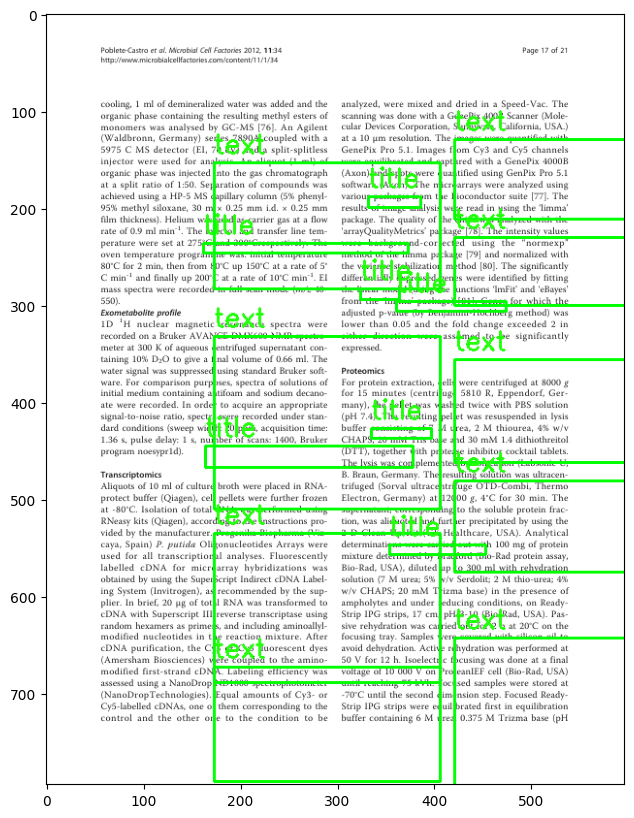

In [ ]:
import matplotlib.pyplot as plt
def visualize(img, anns):
    import cv2
    import numpy as np

    img = cv2.imread(img)
    for ann in anns:
        cls, x, y, w, h = ann
        x = int(float(x) * img.shape[1])
        y = int(float(y) * img.shape[0])
        w = int(float(w) * img.shape[1])
        h = int(float(h) * img.shape[0])
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return img



def read_annotations(label):
    with open(label, "r") as f:
        lines = f.readlines()
    anns = []
    for line in lines:
        cls, x, y, w, h = line.split()
        anns.append((cls, x, y, w, h))
    return anns

seed = 4895
root = r"X:\doc_layout_analysis\publaynet\train-0"
img = os.path.join(root, "images", os.listdir(os.path.join(root, "images"))[seed])
label = os.path.join(root, "labels", os.listdir(os.path.join(root, "labels"))[seed])
anns = read_annotations(label)
img = visualize(img, anns)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()